In [108]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import chi2_contingency, pearsonr
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

pd.set_option('display.max_columns', None)

In [109]:
df = pd.read_csv('flight_weather_merged.csv')

/tmp/ipykernel_29495/3965383140.py:1: DtypeWarning: Columns (30,54) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('flight_weather_merged.csv')


In [110]:
flight_data_train, flight_data_test = train_test_split(df, test_size=0.2, random_state=42)
flight_data_train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 152640 entries, 168320 to 121958
Data columns (total 65 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   aodbuniquefield                152640 non-null  int64  
 1   flightstatus                   152640 non-null  object 
 2   aircraftregistration           152549 non-null  object 
 3   flightnumber                   152640 non-null  object 
 4   traffictypecode                152640 non-null  object 
 5   arrivalordeparture             152640 non-null  object 
 6   lastchanged                    152640 non-null  object 
 7   airlinecode_iata               152640 non-null  object 
 8   airlinecode_icao               152640 non-null  object 
 9   jointflightnumber              15171 non-null   object 
 10  destination_iata               152640 non-null  object 
 11  destination_icao               152640 non-null  object 
 12  via_iata                      

In [111]:
columns_to_drop = [
    "aodbuniquefield",
    "flightstatus",  # not needed as it does not contain the delayed status
    "flightstatuscode",
    "aircraftregistration",
    "actualtakeofftime",
    "metar",
    "time_dubai",
    "checkinallocationfrom",
    "checkinallocationto",
    "actualoffblocktime",  # not required as we have the targets already derived using this
    "publicscheduleddatetime",  # Mostly same as the scheduledoffblocktime
    "estimatedoffblocktime",  # data not available
    "delaytimedelta",  # This is coverted to finalflightstatus for classification and to finalflightstatus for regression
    "wxcodes",
    "airlinenamea",
    "destinationnamea",
    "vianamea",
    "flightstatustexta",
    "arrivalordeparture",
    "lastchanged",
    "scheduledoffblocktime_rounded",
    "station",
    "valid",
    "lon",
    "lat",
    "elevation",
    # 'aircraftterminal'
]

In [112]:
flight_data_train.dtypes

aodbuniquefield           int64
flightstatus             object
aircraftregistration     object
flightnumber             object
traffictypecode          object
                         ...   
skyl4                   float64
wxcodes                  object
feel                    float64
metar                    object
time_dubai               object
Length: 65, dtype: object

In [113]:
def chi_2(df, x, y):
    # Create a contingency table
    contingency_table = pd.crosstab(df[x], df[y])

    # Perform the Chi-Square test
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f"Chi-Square Statistic for {x} and {y}: {chi2}, p-value: {p}, dof:{dof}")

In [114]:
def cramers_v(df, x, y):
    # Create a contingency table
    contingency_table = pd.crosstab(df[x], df[y])
    
    # Perform the Chi-Square test
    chi2, p, _, _ = chi2_contingency(contingency_table)
    
    # Calculate Cramér's V
    n = contingency_table.sum().sum()
    min_dim = min(contingency_table.shape) - 1
    cor = np.sqrt(chi2 / (n * min_dim))
    print(f"Cramer's V  for {x} and {y}: {cor}, p-value: {p}")

Airline code and name

In [115]:
flight_data_train['airlinecode_iata'].nunique()

147

In [116]:
flight_data_train['airlinecode_icao'].nunique()

157

In [117]:
chi_2(flight_data_train, 'airlinecode_iata', 'airlinecode_icao')
cramers_v(flight_data_train, 'airlinecode_iata', 'airlinecode_icao')

Chi-Square Statistic for airlinecode_iata and airlinecode_icao: 22285440.0, p-value: 0.0, dof:22776
Cramer's V  for airlinecode_iata and airlinecode_icao: 1.0, p-value: 0.0


In [118]:
chi_2(flight_data_train, 'airlinecode_iata', 'airlinename')
cramers_v(flight_data_train, 'airlinecode_iata', 'airlinename')

Chi-Square Statistic for airlinecode_iata and airlinename: 22132800.0, p-value: 0.0, dof:22776
Cramer's V  for airlinecode_iata and airlinename: 0.9965694581570854, p-value: 0.0


The p-value is very less than 0.5 and ~0.0 which indicated high correlations so we can drop one of the columns
The Cramers V is also 1 or close to 1

In [119]:
columns_to_drop.append('airlinecode_icao')
columns_to_drop.append('airlinename')

Airpot code

In [120]:
chi_2(flight_data_train, 'destination_icao', 'destination_iata')
cramers_v(flight_data_train, 'destination_icao', 'destination_iata')

Chi-Square Statistic for destination_icao and destination_iata: 46097280.0, p-value: 0.0, dof:93024
Cramer's V  for destination_icao and destination_iata: 0.9967050981266119, p-value: 0.0


In [121]:
chi_2(flight_data_train, 'destinationname', 'destination_iata')
cramers_v(flight_data_train, 'destinationname', 'destination_iata')

Chi-Square Statistic for destinationname and destination_iata: 44850288.00000001, p-value: 0.0, dof:92904
Cramer's V  for destinationname and destination_iata: 1.0, p-value: 0.0


In [122]:
chi_2(flight_data_train, 'destination_icao', 'destinationname')
cramers_v(flight_data_train, 'destination_icao', 'destinationname')

Chi-Square Statistic for destination_icao and destinationname: 44901994.45626953, p-value: 0.0, dof:93852
Cramer's V  for destination_icao and destinationname: 0.9955100263910149, p-value: 0.0


In [123]:
columns_to_drop.append('destination_icao')
columns_to_drop.append('destinationname')

Via codes and name

In [124]:
chi_2(flight_data_train, 'via_icao', 'via_iata')
cramers_v(flight_data_train, 'via_icao', 'via_iata')

chi_2(flight_data_train, 'vianame', 'via_iata')
cramers_v(flight_data_train, 'vianame', 'via_iata')

chi_2(flight_data_train, 'via_icao', 'vianame')
cramers_v(flight_data_train, 'via_icao', 'vianame')


chi_2(flight_data_train, 'via_iata', 'jointflightnumber')
cramers_v(flight_data_train, 'via_iata', 'jointflightnumber')

Chi-Square Statistic for via_icao and via_iata: 556416.0, p-value: 0.0, dof:9216
Cramer's V  for via_icao and via_iata: 1.0, p-value: 0.0
Chi-Square Statistic for vianame and via_iata: 515970.0, p-value: 0.0, dof:8280
Cramer's V  for vianame and via_iata: 1.0, p-value: 0.0
Chi-Square Statistic for via_icao and vianame: 515970.00000000006, p-value: 0.0, dof:8280
Cramer's V  for via_icao and vianame: 1.0, p-value: 0.0
Chi-Square Statistic for via_iata and jointflightnumber: 17388.0, p-value: 0.0, dof:300
Cramer's V  for via_iata and jointflightnumber: 0.9660917830792959, p-value: 0.0


In [125]:
columns_to_drop.append('via_icao')
columns_to_drop.append('vianame')
columns_to_drop.append('jointflightnumber')

Flight and aircraft details

In [126]:
chi_2(flight_data_train, 'flightnumber', 'aircraft_iata')
cramers_v(flight_data_train, 'flightnumber', 'aircraft_iata')
chi_2(flight_data_train, 'aircraft_icao', 'aircraft_iata')
cramers_v(flight_data_train, 'aircraft_icao', 'aircraft_iata')
chi_2(flight_data_train, 'aircraft_icao', 'flightnumber')
cramers_v(flight_data_train, 'aircraft_icao', 'flightnumber')

Chi-Square Statistic for flightnumber and aircraft_iata: 4275166.950258935, p-value: 0.0, dof:129747
Cramer's V  for flightnumber and aircraft_iata: 0.6776063127935088, p-value: 0.0
Chi-Square Statistic for aircraft_icao and aircraft_iata: 7479360.0, p-value: 0.0, dof:3111
Cramer's V  for aircraft_icao and aircraft_iata: 0.9801960588196069, p-value: 0.0
Chi-Square Statistic for aircraft_icao and flightnumber: 3946249.145335343, p-value: 0.0, dof:108477
Cramer's V  for aircraft_icao and flightnumber: 0.7119885077049455, p-value: 0.0


flightnumber and destination_iata

In [127]:
chi_2(flight_data_train, 'flightnumber', 'destination_iata')
cramers_v(flight_data_train, 'flightnumber', 'destination_iata')
chi_2(flight_data_train, 'airlinecode_iata', 'destination_iata')
cramers_v(flight_data_train, 'airlinecode_iata', 'destination_iata')

Chi-Square Statistic for flightnumber and destination_iata: 42758704.49211079, p-value: 0.0, dof:646608
Cramer's V  for flightnumber and destination_iata: 0.9599338330435203, p-value: 0.0
Chi-Square Statistic for airlinecode_iata and destination_iata: 6287768.706140986, p-value: 0.0, dof:44384
Cramer's V  for airlinecode_iata and destination_iata: 0.5311750560417671, p-value: 0.0


In [128]:
columns_to_drop.append('flightnumber')

publicgatenumber and aircraftparkingposition

In [129]:
chi_2(flight_data_train, 'publicgatenumber', 'aircraftparkingposition')
cramers_v(flight_data_train, 'publicgatenumber', 'aircraftparkingposition')


Chi-Square Statistic for publicgatenumber and aircraftparkingposition: 13055413.685544016, p-value: 0.0, dof:33120
Cramer's V  for publicgatenumber and aircraftparkingposition: 0.7880590815625867, p-value: 0.0


In [130]:
columns_to_drop.append('aircraftparkingposition')

In [131]:
print(f'aircraft_iata unique values:{flight_data_train['aircraft_iata'].nunique()}')
print(f'destination_iata unique values:{flight_data_train['destination_iata'].nunique()}')
print(f'airlinecode_iata unique values:{flight_data_train['airlinecode_iata'].nunique()}')
print(f'publicgatenumber unique values:{flight_data_train['publicgatenumber'].nunique()}')

print(f"Total unique values: {flight_data_train['aircraft_iata'].nunique() + flight_data_train['destination_iata'].nunique() + flight_data_train['airlinecode_iata'].nunique() + flight_data_train['publicgatenumber'].nunique()}")



aircraft_iata unique values:62
destination_iata unique values:305
airlinecode_iata unique values:147
publicgatenumber unique values:139
Total unique values: 653


In [132]:
chi_2(flight_data_train, 'destination_iata', 'airlinecode_iata')
cramers_v(flight_data_train, 'destination_iata', 'airlinecode_iata')

Chi-Square Statistic for destination_iata and airlinecode_iata: 6287768.706140986, p-value: 0.0, dof:44384
Cramer's V  for destination_iata and airlinecode_iata: 0.5311750560417671, p-value: 0.0


One out of 'aircraft_icao', 'aircraft_iata' can be dropped

In [133]:
columns_to_drop.append('aircraft_icao')

Traffic type

In [134]:
print(flight_data_train['traffictypecode'].unique())
print(flight_data_train['traffictype'].unique())


['PS' 'PE' 'PC']
['Passenger Scheduled' 'Passenger Extra' 'Passenger Charter']


In [135]:
columns_to_drop.append('traffictype')

Correlation for numerical fields

Text(0.5, 1.0, 'Correlation Heatmap')

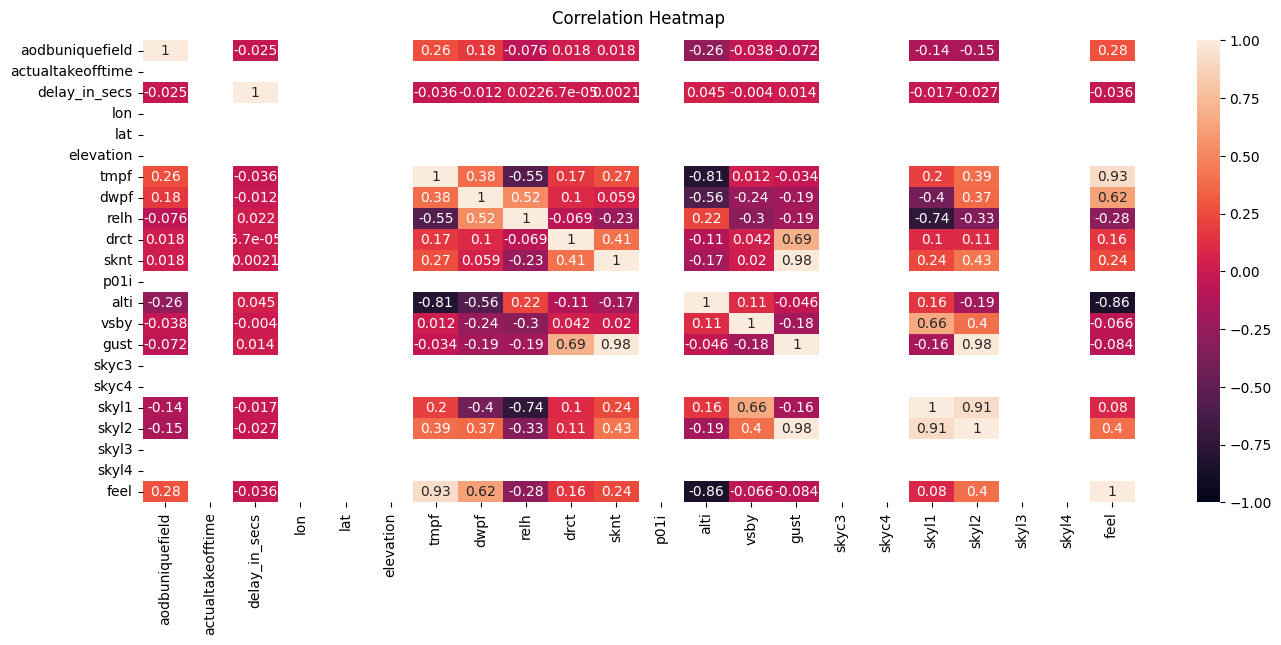

In [136]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(flight_data_train.corr(numeric_only=True), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

tmpf and feel are highly correlated

There are no missing values for feel so we can safetly remove it

In [137]:
columns_to_drop.append('feel')

sknt and gust are correlated

As gust is the sudden increase in speed, it can be explained by wind speed (sknt)

But there are many missing values in gust so we cannot depend on this


In [138]:
pearsonr(flight_data_train['sknt'][flight_data_train['gust'].notna()], flight_data_train['gust'][flight_data_train['gust'].notna()])

PearsonRResult(statistic=0.9792679950850472, pvalue=0.0)

In [139]:
flight_data_train['gust'] = flight_data_train['gust'].notna().astype(int)
flight_data_test['gust'] = flight_data_test['gust'].notna().astype(int)

In [140]:
df.groupby(['aircraft_iata', 'aircraft_icao']).size().reset_index().to_csv('Aircrafts.csv', index=False)


In [141]:
# Drop the duplicate or unnecessary columns
flight_data_train.drop(columns=columns_to_drop, axis=1, inplace=True)
flight_data_test.drop(columns=columns_to_drop, axis=1, inplace=True)

In [142]:
flight_data_train.dtypes

traffictypecode           object
airlinecode_iata          object
destination_iata          object
via_iata                  object
aircraft_iata             object
scheduledoffblocktime     object
publicgatenumber          object
aircraftterminal          object
finalflightstatus         object
delay_in_secs            float64
tmpf                     float64
dwpf                     float64
relh                     float64
drct                     float64
sknt                     float64
p01i                     float64
alti                     float64
vsby                     float64
gust                       int64
skyc1                     object
skyc2                     object
skyc3                    float64
skyc4                    float64
skyl1                    float64
skyl2                    float64
skyl3                    float64
skyl4                    float64
dtype: object

Missing Data

In [143]:
flight_data_train['publicgatenumber'].isnull().sum()

302

In [144]:
flight_data_train['publicgatenumber'].unique()

array(['F6   ', 'B19  ', 'D11  ', 'B6   ', 'B32  ', 'F4   ', 'B14  ',
       'A21  ', 'D2   ', 'A2   ', 'D14  ', 'D16  ', 'A15  ', 'B30  ',
       'C7   ', 'B31  ', 'B8   ', 'F11  ', 'B3   ', 'B2   ', 'B21  ',
       'F8   ', 'D13  ', 'A13  ', 'F2   ', 'B25  ', 'C18  ', 'F10  ',
       'B15  ', 'B29  ', 'D12  ', 'B10  ', 'B11  ', 'C13  ', 'D6   ',
       'A10  ', 'D8   ', 'C23  ', 'A1   ', 'F9   ', 'A4   ', 'A22  ',
       'B20  ', 'C12  ', 'A12  ', 'D18  ', 'B28  ', 'F12  ', 'C19  ',
       'C10  ', 'C15  ', 'C3   ', 'C11  ', 'B27  ', 'A20  ', 'C6   ',
       'D19  ', 'D15  ', 'C46  ', 'B26  ', 'C8   ', 'B12  ', 'C4   ',
       'D10  ', 'D17  ', 'D9   ', 'C17  ', 'C2   ', 'A11  ', 'D21  ',
       'A5   ', 'B31a ', 'D1   ', 'B23  ', 'C21  ', 'B13  ', 'D3   ',
       'D4   ', 'C20  ', 'C5   ', 'B22  ', 'C44  ', 'A24  ', 'A18  ',
       'C22  ', 'B1   ', 'B4   ', 'C9   ', 'F1   ', 'D7   ', 'B18  ',
       'F3   ', 'C1   ', 'A3   ', 'A23  ', 'D5   ', 'F7   ', 'C16  ',
       'B17  ', 'B24

In [145]:
flight_data_train['aircraftterminal'].isnull().sum()

0

In [146]:
flight_data_train[['publicgatenumber', 'aircraftterminal']][flight_data_train['publicgatenumber'].isnull() == True]

,publicgatenumber,aircraftterminal
33207,NaN,3
170368,NaN,1
162258,NaN,2
24069,NaN,3
76875,NaN,PT
...,...,...
46479,NaN,3
110169,NaN,1
49153,NaN,2
78477,NaN,PT


In [147]:
chi_2(flight_data_train, 'publicgatenumber', 'aircraftterminal')
cramers_v(flight_data_train, 'publicgatenumber', 'aircraftterminal')

Chi-Square Statistic for publicgatenumber and aircraftterminal: 364491.43887506856, p-value: 0.0, dof:828
Cramer's V  for publicgatenumber and aircraftterminal: 0.631486275344951, p-value: 0.0


In [148]:
# chi_2(flight_data_train, 'publicgatenumber', 'aircraftparkingposition')
# cramers_v(flight_data_train, 'publicgatenumber', 'aircraftparkingposition')

In [149]:
flight_data_train['publicgatenumber'] = flight_data_train['publicgatenumber'].fillna('UNKNOWN')
flight_data_test['publicgatenumber'] = flight_data_test['publicgatenumber'].fillna('UNKNOWN')

In [150]:
flight_data_train['aircraftterminal'].isnull().sum()

0

In [151]:
flight_data_train.isnull().sum()

traffictypecode               0
airlinecode_iata              0
destination_iata              0
via_iata                 146844
aircraft_iata                 0
scheduledoffblocktime         0
publicgatenumber              0
aircraftterminal              0
finalflightstatus             0
delay_in_secs                 0
tmpf                          0
dwpf                          0
relh                          0
drct                          0
sknt                          0
p01i                          0
alti                          0
vsby                          0
gust                          0
skyc1                    108439
skyc2                    152443
skyc3                    152640
skyc4                    152640
skyl1                    136195
skyl2                    152452
skyl3                    152640
skyl4                    152640
dtype: int64

via_iata

Instead of maintaining the details of connecting flight we can change it indicate if the flight is connection

In [152]:
flight_data_train['isconnecting'] = flight_data_train['via_iata'].notna().map({True: '1', False: '0'})
flight_data_test['isconnecting'] = flight_data_test['via_iata'].notna().map({True: '1', False: '0'})


flight_data_train.drop(columns='via_iata', axis=1, inplace=True)
flight_data_test.drop(columns='via_iata', axis=1, inplace=True)

In [153]:
flight_data_train['isconnecting'].unique()

array(['0', '1'], dtype=object)

In [154]:
print(f'skyc1 unique values:{flight_data_train['skyc1'].unique()}')
print(f'skyc2 unique values:{flight_data_train['skyc2'].unique()}')
print(f'skyc3 unique values:{flight_data_train['skyc3'].unique()}')
print(f'skyc4 unique values:{flight_data_train['skyc4'].unique()}')

print(f'skyl1 unique values:{flight_data_train['skyl1'].unique()}')
print(f'skyl2 unique values:{flight_data_train['skyl2'].unique()}')
print(f'skyl3 unique values:{flight_data_train['skyl3'].unique()}')
print(f'skyl4 unique values:{flight_data_train['skyl4'].unique()}')

skyc1 unique values:['NSC' nan 'FEW' 'BKN' 'SCT' 'VV ' 'OVC']
skyc2 unique values:[nan 'FEW' 'NSC' 'SCT' 'BKN']
skyc3 unique values:[nan]
skyc4 unique values:[nan]
skyl1 unique values:[  nan 4500. 4000. 3200.  800.  300. 2300. 3000.  700. 2600. 1700. 2500.
  100. 3500. 1500. 2800. 3300. 1800. 1100. 4800. 4700.  600.  200. 2000.
 1600. 2100. 3800. 4900. 3600. 2400. 3700. 2700. 3100. 4300. 1300. 4600.
 1400. 2900. 2200. 1000.  900. 1900.  500.  400. 4100. 1200. 5000. 4200.
 7000. 4400.]
skyl2 unique values:[  nan 5000. 4000. 3000. 1400. 4500. 3500.]
skyl3 unique values:[nan]
skyl4 unique values:[nan]


We can drop skyc3, skyc4, skyl3 and skyl4 as they are mostly empty

In [155]:
flight_data_train.drop(columns=['skyc3', 'skyc4', 'skyl3', 'skyl4'], axis=1, inplace=True)
flight_data_test.drop(columns=['skyc3', 'skyc4', 'skyl3', 'skyl4'], axis=1, inplace=True)

In [156]:
# Replace missing values in 'skyc1' and 'skyc2' with 'NA'
flight_data_train[['skyc1', 'skyc2']] = flight_data_train[['skyc1', 'skyc2']].fillna('CAVOK') # From METAR code
flight_data_test[['skyc1', 'skyc2']] = flight_data_test[['skyc1', 'skyc2']].fillna('CAVOK')

# Replace missing values in 'skyl1' and 'skyl2' with 0
flight_data_train[['skyl1', 'skyl2']] = flight_data_train[['skyl1', 'skyl2']].fillna(0)
flight_data_test[['skyl1', 'skyl2']] = flight_data_test[['skyl1', 'skyl2']].fillna(0)

In [157]:
flight_data_train.isna().sum()

traffictypecode          0
airlinecode_iata         0
destination_iata         0
aircraft_iata            0
scheduledoffblocktime    0
publicgatenumber         0
aircraftterminal         0
finalflightstatus        0
delay_in_secs            0
tmpf                     0
dwpf                     0
relh                     0
drct                     0
sknt                     0
p01i                     0
alti                     0
vsby                     0
gust                     0
skyc1                    0
skyc2                    0
skyl1                    0
skyl2                    0
isconnecting             0
dtype: int64

In [158]:
flight_data_test.columns

Index(['traffictypecode', 'airlinecode_iata', 'destination_iata',
       'aircraft_iata', 'scheduledoffblocktime', 'publicgatenumber',
       'aircraftterminal', 'finalflightstatus', 'delay_in_secs', 'tmpf',
       'dwpf', 'relh', 'drct', 'sknt', 'p01i', 'alti', 'vsby', 'gust', 'skyc1',
       'skyc2', 'skyl1', 'skyl2', 'isconnecting'],
      dtype='object')

In [159]:
flight_data_train['aircraftterminal'].unique()

array(['2 ', 3, '1 ', 'PT', 1, '3 ', 2], dtype=object)

In [160]:
aircraftterminal_map = {0: 0, 1: 1, 2: 2, 3: 3, "2 ": 2, "1 ": 1, "3 ": 3, "PT": 0}
flight_data_train["aircraftterminal"] = flight_data_train["aircraftterminal"].map(
    aircraftterminal_map
)
flight_data_test["aircraftterminal"] = flight_data_test["aircraftterminal"].map(
    aircraftterminal_map
)

In [161]:
flight_data_train['aircraftterminal'].unique()

array([2, 3, 1, 0])

In [162]:
print(flight_data_train['p01i'].value_counts())
print(flight_data_test['p01i'].value_counts())


p01i
0.0    152640
Name: count, dtype: int64
p01i
0.0    38161
Name: count, dtype: int64


In [163]:
non_numeric_columns = list(set(flight_data_train.columns)-set(flight_data_train._get_numeric_data().columns))
for col in non_numeric_columns:
    flight_data_train[col] = flight_data_train[col].apply(lambda x : str(x).strip())
    flight_data_test[col] = flight_data_test[col].apply(lambda x : str(x).strip())

In [164]:
cols = [
    # "flightnumber",
    "scheduledoffblocktime",
    "traffictypecode",
    "airlinecode_iata",
    "destination_iata",
    "aircraft_iata",
    "isconnecting",
    # "aircraftparkingposition",
    "publicgatenumber",
    "aircraftterminal",
    "tmpf",
    "dwpf",
    "relh",
    "drct",
    "sknt",
    "alti",
    "vsby",
    "gust",
    "skyc1",
    "skyc2",
    "skyl1",
    "skyl2",
    "finalflightstatus",
    "delay_in_secs",
]

In [165]:
flight_data_train.isnull().sum()

traffictypecode          0
airlinecode_iata         0
destination_iata         0
aircraft_iata            0
scheduledoffblocktime    0
publicgatenumber         0
aircraftterminal         0
finalflightstatus        0
delay_in_secs            0
tmpf                     0
dwpf                     0
relh                     0
drct                     0
sknt                     0
p01i                     0
alti                     0
vsby                     0
gust                     0
skyc1                    0
skyc2                    0
skyl1                    0
skyl2                    0
isconnecting             0
dtype: int64

In [58]:
flight_data_train[cols].to_csv('./flight_data_train.csv', index=False)
flight_data_test[cols].to_csv('./flight_data_test.csv', index=False)

# flight_data_train = flight_data_train[cols].reset_index(drop=True)
# flight_data_test = flight_data_test[cols].reset_index(drop=True)